In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import os
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from itertools import product

from matplotlib import pyplot as plt
%matplotlib inline

/usr/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def get_mean_cv_acc(estimator, X, y, n_splits=5, seed=17, shuffle=True):
    cv = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=shuffle)
    return cross_val_score(estimator, X, y, scoring='accuracy', cv=cv).mean()

In [3]:
def add_real_time(df):
    df['request_time'] = df['request_ts'].apply(datetime.fromtimestamp)
    df['trans_time'] = df['trans_ts'].apply(datetime.fromtimestamp)

In [4]:
def get_train_test_df(df):
    train_df = df[(df['label'] != '?') & (df['label'] != '-')].reset_index(drop=True)
    test_df = df[df['label'] == '?'].reset_index(drop=True)
    train_df['label'] = train_df['label'].astype(int)
    y_train = train_df['label'].values.astype(int)
    test_df.drop('label', axis=1, inplace=True)
    return train_df, y_train, test_df

In [5]:
data = pd.read_csv('data/transport_data.csv')
data.head()

,log,lat,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,0
1,30.219528,59.954617,1511956827,1511956746,-
2,30.409101,59.931679,1511956827,1511956747,-
3,30.293602,59.938892,1511956827,1511956759,-
4,30.360102,59.931103,1511956827,1511956767,-


In [6]:
data.shape

(58665, 5)

In [7]:
labeled_data, labels, test_data = get_train_test_df(data)
labeled_data.head()

,log,lat,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,0
1,30.385973,59.944260,1511956827,1511956782,0
2,30.374880,59.938213,1511956827,1511956802,1
3,30.347544,59.932667,1511956827,1511956811,0
4,30.312321,59.937405,1511956827,1511956820,2


In [8]:
test_data.head()

,log,lat,request_ts,trans_ts
0,30.359190,59.931217,1511956827,1511956787
1,30.355488,59.931679,1511956827,1511956811
2,30.312258,59.937222,1511956918,1511956905
3,30.367332,59.931988,1511956918,1511956907
4,30.329239,59.934929,1511956978,1511956967


In [9]:
labels[:10]

array([0, 0, 1, 0, 2, 0, 1, 0, 0, 0])

In [10]:
labeled_data.shape, labels.shape, test_data.shape

((10000, 5), (10000,), (5000, 4))

In [11]:
pd.value_counts(labels)

0    4423
1    3372
2    2205
dtype: int64

In [12]:
train_data, valid_data, y_train, y_valid = train_test_split(labeled_data.drop('label', axis=1), labels, 
                                                            test_size=0.3, random_state=17, 
                                                            shuffle=True, stratify=labels)

In [13]:
train_data.shape, valid_data.shape, y_train.shape, y_valid.shape

((7000, 4), (3000, 4), (7000,), (3000,))

** Train with based features **

In [14]:
forest = RandomForestClassifier(n_estimators=100, random_state=17)
logit = LogisticRegression(random_state=17)
xgb_clf = XGBClassifier(n_estimators=100, random_state=17)
knn = KNeighborsClassifier(n_neighbors=99)
svc = SVC(random_state=17)

algorithms = [forest, logit, xgb_clf, knn, svc]

In [200]:
features = [['log', 'lat', 'request_ts', 'trans_ts'], ['log', 'lat', 'request_ts'], 
            ['log', 'lat', 'trans_ts'], ['log', 'lat']]

**Random Forest**

In [201]:
%%time
for columns in features:
    print(columns, get_mean_cv_acc(forest, labeled_data[columns], labels))

['log', 'lat', 'request_ts', 'trans_ts'] 0.5909958679739669
['log', 'lat', 'request_ts'] 0.5877978676744668
['log', 'lat', 'trans_ts'] 0.5882979676244918
['log', 'lat'] 0.5634001132000284
CPU times: user 25.9 s, sys: 10.1 ms, total: 25.9 s
Wall time: 26 s


**Logit**

In [202]:
%%time
for columns in features:
    print(columns, get_mean_cv_acc(logit, labeled_data[columns], labels))

['log', 'lat', 'request_ts', 'trans_ts'] 0.4422999884499971
['log', 'lat', 'request_ts'] 0.4422999884499971
['log', 'lat', 'trans_ts'] 0.4422999884499971
['log', 'lat'] 0.5060015013003752
CPU times: user 371 ms, sys: 25 µs, total: 371 ms
Wall time: 368 ms


**Gradient Boosting**

In [203]:
%%time
for columns in features:
    print(columns, get_mean_cv_acc(xgb_clf, labeled_data[columns], labels))

['log', 'lat', 'request_ts', 'trans_ts'] 0.5751998153499539
['log', 'lat', 'request_ts'] 0.5742997651249413
['log', 'lat', 'trans_ts'] 0.5747002152500538
['log', 'lat'] 0.5755996155499038
CPU times: user 12.7 s, sys: 26.7 ms, total: 12.7 s
Wall time: 12.7 s


**KNN**

In [204]:
%%time
for columns in features:
    print(columns, get_mean_cv_acc(knn, labeled_data[columns], labels))

['log', 'lat', 'request_ts', 'trans_ts'] 0.44690103922525976
['log', 'lat', 'request_ts'] 0.44660003912500984
['log', 'lat', 'trans_ts'] 0.4476007393251848
['log', 'lat'] 0.5635001134000284
CPU times: user 1.44 s, sys: 9.97 ms, total: 1.45 s
Wall time: 1.86 s


**SVM**

In [206]:
%%time
for columns in features:
    print(columns, get_mean_cv_acc(svc, labeled_data[columns], labels))

['log', 'lat', 'request_ts', 'trans_ts'] 0.43070068580017146
['log', 'lat', 'request_ts'] 0.38799992792498195
['log', 'lat', 'trans_ts'] 0.45170104017526
['log', 'lat'] 0.48829994762498685
CPU times: user 58.1 s, sys: 16.9 ms, total: 58.2 s
Wall time: 58.4 s


In [16]:
add_real_time(data)
add_real_time(labeled_data)
add_real_time(train_data)
add_real_time(valid_data)
add_real_time(test_data)

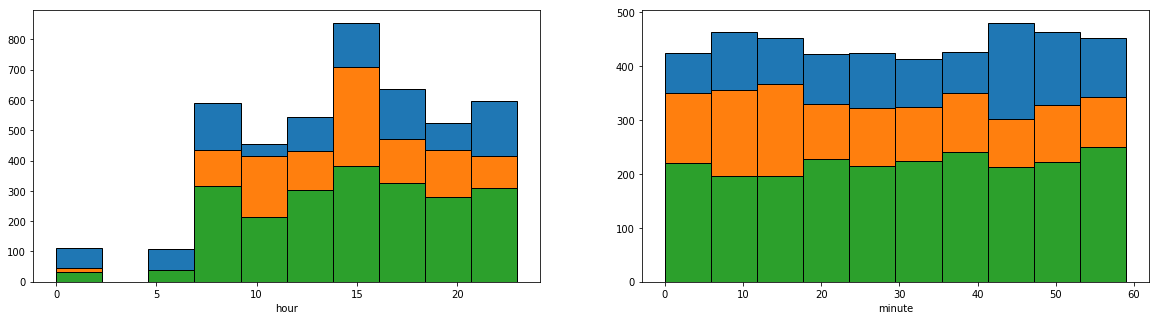

In [209]:
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(1, 2, 1)
plt.hist(labeled_data[labels == 0]['trans_time'].apply(lambda ts: ts.hour), edgecolor='black')
plt.hist(labeled_data[labels == 1]['trans_time'].apply(lambda ts: ts.hour), edgecolor='black')
plt.hist(labeled_data[labels == 2]['trans_time'].apply(lambda ts: ts.hour), edgecolor='black')
plt.xlabel('hour')

fig.add_subplot(1, 2, 2)
plt.hist(labeled_data[labels == 0]['trans_time'].apply(lambda ts: ts.minute), edgecolor='black')
plt.hist(labeled_data[labels == 1]['trans_time'].apply(lambda ts: ts.minute), edgecolor='black')
plt.hist(labeled_data[labels == 2]['trans_time'].apply(lambda ts: ts.minute), edgecolor='black')
plt.xlabel('minute');

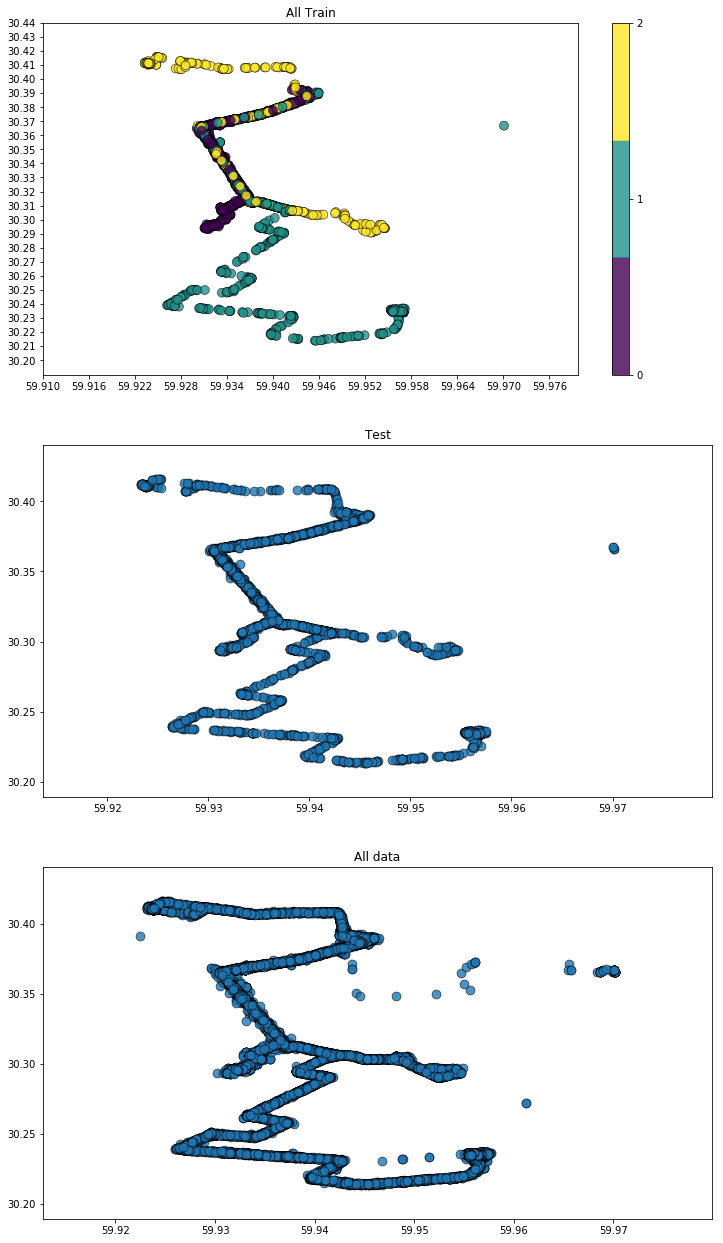

In [210]:
fig = plt.figure(figsize=(12, 22))

fig.add_subplot(3, 1, 1)
coordinates = labeled_data[['lat', 'log']].values
cmap = plt.get_cmap('viridis', 3)
plt.scatter(coordinates[:,0], coordinates[:,1], c=labels, edgecolors='black', linewidth=0.6, alpha=0.8, s=80, 
            cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])
plt.title('All Train')
plt.yticks(np.arange(30.2, 30.45, 0.01))
plt.xticks(np.arange(59.91, 59.98, 0.006))


fig.add_subplot(3, 1, 2)
plt.scatter(test_data['lat'], test_data['log'], edgecolors='black', linewidth=0.6, alpha=0.8, s=80)
plt.title('Test')


fig.add_subplot(3, 1, 3)
plt.scatter(data['lat'], data['log'], edgecolors='black', linewidth=0.6, alpha=0.8, s=80)
plt.title('All data');

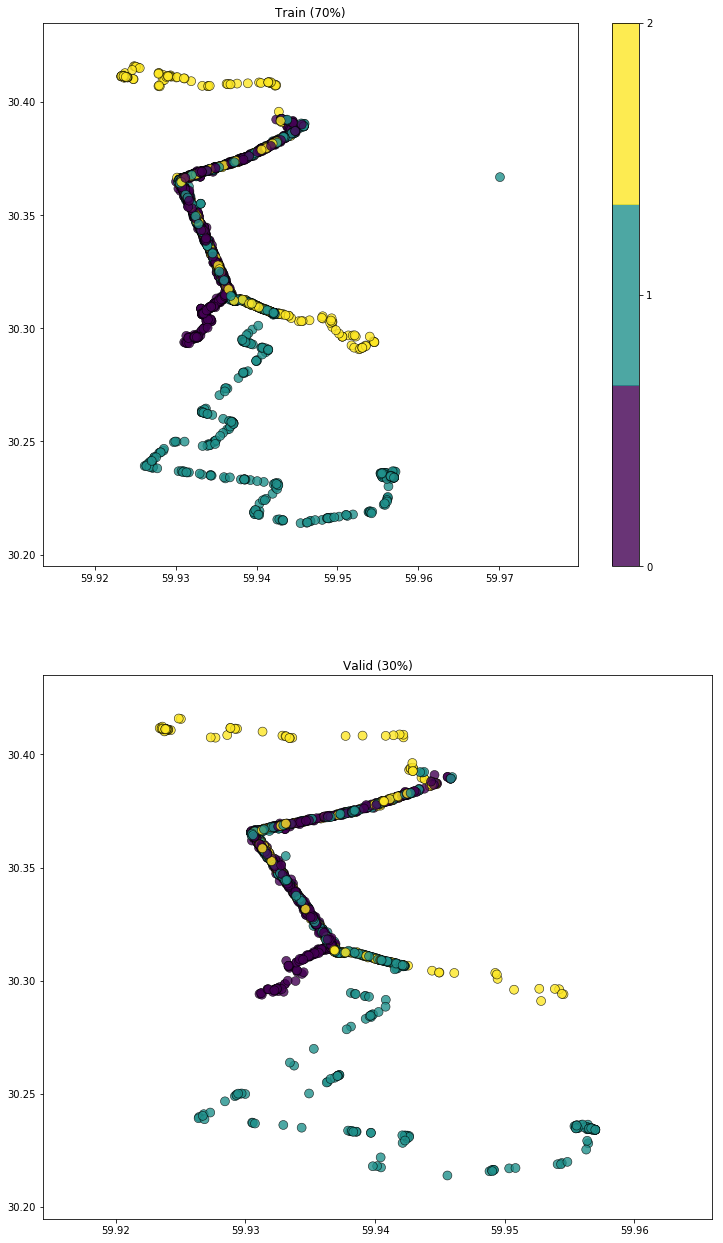

In [212]:
fig = plt.figure(figsize=(12, 22))

fig.add_subplot(2, 1, 1)
coordinates = train_data[['lat', 'log']].values
cmap = plt.get_cmap('viridis', 3)
plt.scatter(coordinates[:,0], coordinates[:,1], c=y_train, edgecolors='black', linewidth=0.6, alpha=0.8, s=80, 
            cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])
plt.title('Train (70%)')


fig.add_subplot(2, 1, 2)
plt.scatter(valid_data['lat'], valid_data['log'], c=y_valid, edgecolors='black', linewidth=0.6, alpha=0.8, s=80, 
            cmap=cmap)
plt.title('Valid (30%)');

In [46]:
def add_xyz_features(df):
    df['x'] = df['lat'].apply(np.cos) * df['log'].apply(np.cos)
    df['y'] = df['lat'].apply(np.cos) * df['log'].apply(np.sin)
    df['z'] = df['lat'].apply(np.sin)

In [47]:
add_xyz_features(data)
add_xyz_features(labeled_data)
add_xyz_features(train_data)
add_xyz_features(valid_data)
add_xyz_features(test_data)

In [216]:
algorithms = [forest, xgb_clf, knn]

In [217]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, labeled_data[['x', 'y', 'z']], labels))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.5598004621751156
<class 'xgboost.sklearn.XGBClassifier'> 0.5766003156000788
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.5635000134500034
CPU times: user 9.51 s, sys: 20.1 ms, total: 9.53 s
Wall time: 9.53 s


In [218]:
data[data['log'] <= 30.29]['label'].value_counts()

-    12444
?      896
1      433
Name: label, dtype: int64

In [219]:
data[data['log'] >= 30.39263]['label'].value_counts()

-    4747
?     295
2     179
Name: label, dtype: int64

In [220]:
data.loc[data[(data['label'] == '-') & (data['log'] <= 30.29)].index, 'label'] = '1'

In [221]:
labeled_data, labels, test_data = get_train_test_df(data)
labeled_data.head()

,log,lat,request_ts,trans_ts,label,request_time,trans_time,x,y,z
0,30.295780,59.932167,1511956827,1511956594,0,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554
1,30.219528,59.954617,1511956827,1511956746,1,2017-11-29 15:00:27,2017-11-29 14:59:06,-0.353008,0.898395,-0.261288
2,30.385973,59.944260,1511956827,1511956782,0,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277
3,30.236233,59.955753,1511956827,1511956783,1,2017-11-29 15:00:27,2017-11-29 14:59:43,-0.367852,0.892098,-0.262385
4,30.374880,59.938213,1511956827,1511956802,1,2017-11-29 15:00:27,2017-11-29 15:00:02,-0.489863,0.836542,-0.245420


In [222]:
labeled_data.shape, labels.shape, test_data.shape

((22444, 10), (22444,), (5000, 9))

In [223]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, labeled_data[['log', 'lat']], labels))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.8068526850768081
<class 'xgboost.sklearn.XGBClassifier'> 0.8104614867994613
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.8065407122609807
CPU times: user 13.3 s, sys: 13.4 ms, total: 13.3 s
Wall time: 13.3 s


In [224]:
data.loc[data[(data['label'] == '-') & (data['log'] >= 30.39263)].index, 'label'] = '2'

In [225]:
labeled_data, labels, test_data = get_train_test_df(data)
labeled_data.head()

,log,lat,request_ts,trans_ts,label,request_time,trans_time,x,y,z
0,30.295780,59.932167,1511956827,1511956594,0,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554
1,30.219528,59.954617,1511956827,1511956746,1,2017-11-29 15:00:27,2017-11-29 14:59:06,-0.353008,0.898395,-0.261288
2,30.409101,59.931679,1511956827,1511956747,2,2017-11-29 15:00:27,2017-11-29 14:59:07,-0.519045,0.820630,-0.239080
3,30.385973,59.944260,1511956827,1511956782,0,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277
4,30.236233,59.955753,1511956827,1511956783,1,2017-11-29 15:00:27,2017-11-29 14:59:43,-0.367852,0.892098,-0.262385


In [226]:
labeled_data.shape, labels.shape, test_data.shape

((27191, 10), (27191,), (5000, 9))

In [227]:
pd.value_counts(labels)

1    15816
2     6952
0     4423
dtype: int64

In [228]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, labeled_data[['log', 'lat']], labels))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.8403145431061001
<class 'xgboost.sklearn.XGBClassifier'> 0.8436611725195917
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.8403515714632521
CPU times: user 15.9 s, sys: 10.1 ms, total: 15.9 s
Wall time: 15.9 s


In [230]:
xgb_clf.fit(labeled_data[['log', 'lat']], labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=17,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

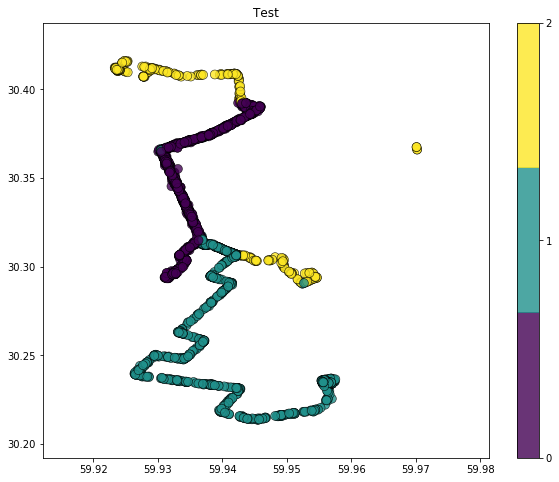

In [232]:
plt.figure(figsize=(10, 8))
y_pred = xgb_clf.predict(test_data[['log', 'lat']])
cmap = plt.get_cmap('viridis', 3)
plt.scatter(test_data['lat'], test_data['log'], edgecolors='black', c=y_pred, linewidth=0.6, alpha=0.8, s=80,
            cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])             
plt.title('Test');

In [17]:
def add_numeric_time_features(df):
    df['hour'] = df['trans_time'].apply(lambda ts: ts.hour)
    df['minute'] = df['trans_time'].apply(lambda ts: ts.minute)
    df['second'] = df['trans_time'].apply(lambda ts: ts.second)
    df['HHMMSS'] = df['trans_time'].apply(lambda ts: (ts.hour * 100 + ts.minute) * 100 + ts.second)
    df['HHMM'] = df['trans_time'].apply(lambda ts: ts.hour * 100 + ts.minute)
    df['MMSS'] = df['trans_time'].apply(lambda ts: ts.minute * 100 + ts.second)
    
    df['dow'] = df['trans_time'].apply(lambda ts: ts.dayofweek)

In [234]:
add_numeric_time_features(labeled_data)
labeled_data.head()

,log,lat,request_ts,trans_ts,label,request_time,trans_time,x,y,z,hour,minute,second,HHMMSS,HHMM,MMSS,dow
0,30.295780,59.932167,1511956827,1511956594,0,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554,14,56,34,145634,1456,5634,2
1,30.219528,59.954617,1511956827,1511956746,1,2017-11-29 15:00:27,2017-11-29 14:59:06,-0.353008,0.898395,-0.261288,14,59,6,145906,1459,5906,2
2,30.409101,59.931679,1511956827,1511956747,2,2017-11-29 15:00:27,2017-11-29 14:59:07,-0.519045,0.820630,-0.239080,14,59,7,145907,1459,5907,2
3,30.385973,59.944260,1511956827,1511956782,0,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277,14,59,42,145942,1459,5942,2
4,30.236233,59.955753,1511956827,1511956783,1,2017-11-29 15:00:27,2017-11-29 14:59:43,-0.367852,0.892098,-0.262385,14,59,43,145943,1459,5943,2


In [235]:
%%time
numeric_time_features = ['hour', 'minute', 'second', 'HHMMSS', 'HHMM', 'MMSS']
for time_feature in numeric_time_features:
    print(time_feature, get_mean_cv_acc(xgb_clf, labeled_data[['log', 'lat', time_feature]], labels))

hour 0.8433670143083101
minute 0.8436611589932111
second 0.8436611995773259
HHMMSS 0.8436244010567346
HHMM 0.8437347695557993
MMSS 0.8436243807634343
CPU times: user 53 s, sys: 130 ms, total: 53.1 s
Wall time: 53.7 s


In [236]:
print('Day of week', get_mean_cv_acc(xgb_clf, labeled_data[['log', 'lat', 'dow']], labels))

Day of week 0.8436611995698666


In [237]:
data.query('lat <= 59.93489 & log <= 30.33 & log > 30.29')['label'].value_counts()

-    4850
?     405
0     285
Name: label, dtype: int64

In [238]:
data.loc[data.query('lat <= 59.93489 & log <= 30.33 & log > 30.29 & label == "-"').index, 'label'] = '0'

In [239]:
labeled_data, labels, test_data = get_train_test_df(data)
labeled_data.head()

,log,lat,request_ts,trans_ts,label,request_time,trans_time,x,y,z
0,30.295780,59.932167,1511956827,1511956594,0,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554
1,30.219528,59.954617,1511956827,1511956746,1,2017-11-29 15:00:27,2017-11-29 14:59:06,-0.353008,0.898395,-0.261288
2,30.409101,59.931679,1511956827,1511956747,2,2017-11-29 15:00:27,2017-11-29 14:59:07,-0.519045,0.820630,-0.239080
3,30.385973,59.944260,1511956827,1511956782,0,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277
4,30.236233,59.955753,1511956827,1511956783,1,2017-11-29 15:00:27,2017-11-29 14:59:43,-0.367852,0.892098,-0.262385


In [240]:
labeled_data.shape, labels.shape, test_data.shape

((32041, 10), (32041,), (5000, 9))

In [242]:
pd.value_counts(labels)

1    15816
0     9273
2     6952
dtype: int64

In [243]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, labeled_data[['log', 'lat']], labels))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.866452232735399
<class 'xgboost.sklearn.XGBClassifier'> 0.8677005358586456
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.8645172878656361
CPU times: user 20.3 s, sys: 20.1 ms, total: 20.3 s
Wall time: 20.4 s


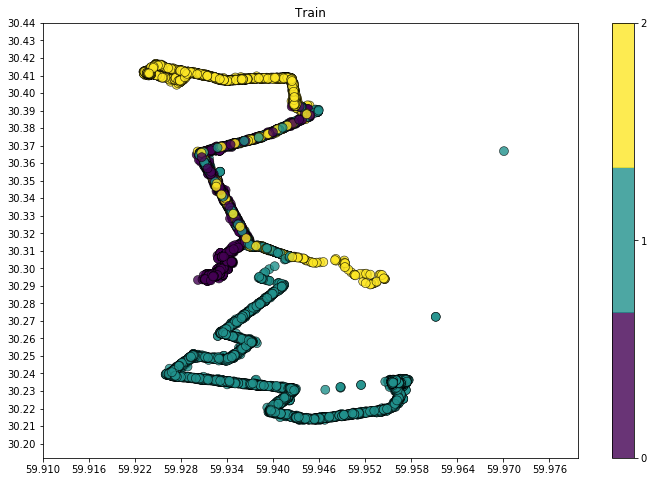

In [244]:
fig = plt.figure(figsize=(12, 8))

cmap = plt.get_cmap('viridis', 3)
plt.scatter(labeled_data['lat'], labeled_data['log'], c=labels, edgecolors='black', linewidth=0.6, alpha=0.8, s=80, 
            cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])
plt.title('Train')
plt.yticks(np.arange(30.2, 30.45, 0.01))
plt.xticks(np.arange(59.91, 59.98, 0.006));

In [245]:
data.loc[data.query('lat >= 59.942383 & log <= 30.32 & log >= 30.29 & label == "-"').index, 'label'] = '2'

In [246]:
labeled_data, labels, test_data = get_train_test_df(data)
labeled_data.head()

,log,lat,request_ts,trans_ts,label,request_time,trans_time,x,y,z
0,30.295780,59.932167,1511956827,1511956594,0,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554
1,30.219528,59.954617,1511956827,1511956746,1,2017-11-29 15:00:27,2017-11-29 14:59:06,-0.353008,0.898395,-0.261288
2,30.409101,59.931679,1511956827,1511956747,2,2017-11-29 15:00:27,2017-11-29 14:59:07,-0.519045,0.820630,-0.239080
3,30.385973,59.944260,1511956827,1511956782,0,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277
4,30.236233,59.955753,1511956827,1511956783,1,2017-11-29 15:00:27,2017-11-29 14:59:43,-0.367852,0.892098,-0.262385


In [247]:
labeled_data.shape, labels.shape, test_data.shape

((33774, 10), (33774,), (5000, 9))

In [249]:
pd.value_counts(labels)

1    15816
0     9273
2     8685
dtype: int64

In [250]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, labeled_data[['log', 'lat']], labels))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.873245511581141
<class 'xgboost.sklearn.XGBClassifier'> 0.874074776978205
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.8724759130391639
CPU times: user 20.8 s, sys: 16.7 ms, total: 20.8 s
Wall time: 20.8 s


In [251]:
%%time
xgb_clf.fit(labeled_data[['log', 'lat']], labels)

CPU times: user 2.24 s, sys: 6.55 ms, total: 2.25 s
Wall time: 2.25 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=17,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [252]:
y_pred = xgb_clf.predict(test_data[['log', 'lat']]) #0.6794
with open(os.path.join('data', 'transport_subm1.csv'), 'w') as f:
    f.write('\n'.join([str(y) for y in y_pred]))

In [254]:
%%time
neighbors = range(1, 100)
cv_results = []
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    cv_score = get_mean_cv_acc(model, labeled_data[['log', 'lat']], labels)
    cv_results.append(cv_score)
    print(f'neighbors: {n}, cv score: {cv_score}')

neighbors: 1, cv score: 0.8655178891607301
neighbors: 2, cv score: 0.8724461563190719
neighbors: 3, cv score: 0.8669981031200742
neighbors: 4, cv score: 0.8666132731844032
neighbors: 5, cv score: 0.8660505296714914
neighbors: 6, cv score: 0.8661099510832383
neighbors: 7, cv score: 0.8655177445132833
neighbors: 8, cv score: 0.868123173755339
neighbors: 9, cv score: 0.8670573185316499
neighbors: 10, cv score: 0.8672941888779266
neighbors: 11, cv score: 0.8681527069247759
neighbors: 12, cv score: 0.8688633136058325
neighbors: 13, cv score: 0.8680934520804129
neighbors: 14, cv score: 0.8685967785847717
neighbors: 15, cv score: 0.8687449441769326
neighbors: 16, cv score: 0.8685080913603767
neighbors: 17, cv score: 0.869337089386377
neighbors: 18, cv score: 0.8697811829403553
neighbors: 19, cv score: 0.8700181321885427
neighbors: 20, cv score: 0.8693667452937053
neighbors: 21, cv score: 0.8698405473662352
neighbors: 22, cv score: 0.8702254781198608
neighbors: 23, cv score: 0.8704623134144827

In [255]:
np.argmax(cv_results) + 1, np.max(cv_results)

(75, 0.8730976001945849)

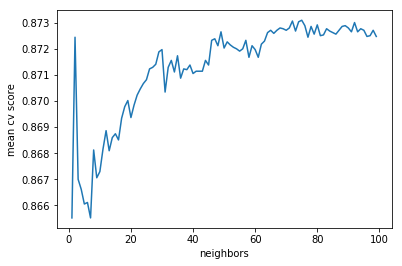

In [256]:
plt.plot(neighbors, cv_results)
plt.xlabel('neighbors')
plt.ylabel('mean cv score');

In [258]:
distances = [1, 2, 3, 4, 5]

for p in distances:
    model = KNeighborsClassifier(n_neighbors=77, p=p)
    cv_score = get_mean_cv_acc(model, labeled_data[['log', 'lat']], labels)
    cv_results.append(cv_score)
    print(f'p: {p}, cv score: {cv_score}')

p: 1, cv score: 0.8734529101068119
p: 2, cv score: 0.8724462001433733
p: 3, cv score: 0.8727127001140771
p: 4, cv score: 0.8725646528553161
p: 5, cv score: 0.8723869978985539


In [259]:
knn = KNeighborsClassifier(n_neighbors=77)

In [260]:
%%time
knn.fit(labeled_data[['log', 'lat']], labels)

CPU times: user 34.6 ms, sys: 22 µs, total: 34.6 ms
Wall time: 33.6 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=77, p=2,
           weights='uniform')

In [261]:
y_pred = knn.predict(test_data[['log', 'lat']]) #0.6726
with open(os.path.join('data', 'transport_subm2.csv'), 'w') as f:
    f.write('\n'.join([str(y) for y in y_pred]))

In [262]:
%%time
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(labeled_data[['log', 'lat']], labels)

CPU times: user 20.6 ms, sys: 0 ns, total: 20.6 ms
Wall time: 19.7 ms


In [263]:
y_pred = knn.predict(test_data[['log', 'lat']]) #0.6786
with open(os.path.join('data', 'transport_subm3.csv'), 'w') as f:
    f.write('\n'.join([str(y) for y in y_pred]))

In [264]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, labeled_data[['log', 'lat', 'request_ts', 'trans_ts']], labels))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.8793154009433752
<class 'xgboost.sklearn.XGBClassifier'> 0.8744892803703909
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.4740332025881826
CPU times: user 29.6 s, sys: 20.4 ms, total: 29.6 s
Wall time: 29.7 s


In [265]:
scaler = StandardScaler()
scaled_labeled_data = scaler.fit_transform(labeled_data[['log', 'lat', 'request_ts', 'trans_ts']])
print(algo.__class__, get_mean_cv_acc(algo, scaled_labeled_data, labels))

<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.8627050482340337


**Unlabeled data with XGB**

In [17]:
data = pd.read_csv('data/transport_data.csv')
labeled_data, labels, test_data = get_train_test_df(data)

In [18]:
labeled_data.shape, labels.shape

((10000, 5), (10000,))

In [19]:
unlabeled_data = data[data['label'] == '-']
unlabeled_data.drop('label', axis=1, inplace=True)
unlabeled_data.shape

(43665, 4)

In [20]:
X_unlabeled = unlabeled_data.values

In [21]:
xgb_clf.fit(labeled_data.drop('label', axis=1).values, labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=17,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
unlabeled_probs = xgb_clf.predict_proba(X_unlabeled)
unlabeled_pred = unlabeled_probs.argmax(axis=1)

In [23]:
unlabeled_data['prob'] = unlabeled_probs.max(axis=1)
unlabeled_data['label'] = unlabeled_pred
unlabeled_data.head()

,log,lat,request_ts,trans_ts,prob,label
1,30.219528,59.954617,1511956827,1511956746,0.996017,1
2,30.409101,59.931679,1511956827,1511956747,0.978982,2
3,30.293602,59.938892,1511956827,1511956759,0.947870,1
4,30.360102,59.931103,1511956827,1511956767,0.609441,0
5,30.309683,59.940006,1511956827,1511956769,0.734577,1


In [24]:
unlabeled_data_th09 = unlabeled_data[unlabeled_data['prob'] > 0.9]
unlabeled_data_th09.shape

(24412, 6)

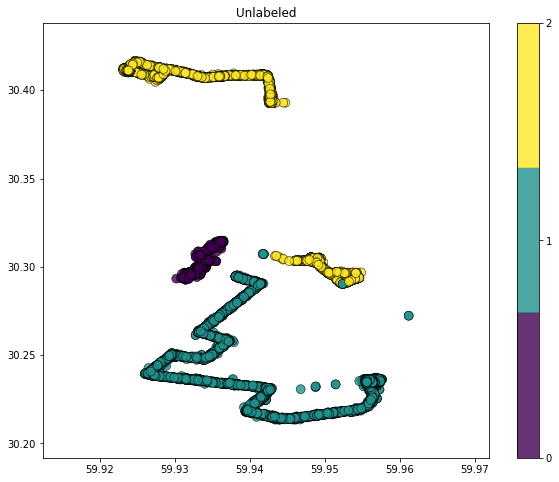

In [23]:
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('viridis', 3)
plt.scatter(unlabeled_data_th09['lat'], unlabeled_data_th09['log'], edgecolors='black', 
            c=unlabeled_data_th09['label'], linewidth=0.6, alpha=0.8, s=80, cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])             
plt.title('Unlabeled');

In [25]:
y_unlabeled = unlabeled_data_th09['label'].values
X_mixed_train = np.vstack((train_data.values, unlabeled_data_th09.drop(['prob', 'label'], axis=1).values))
y_mixed_train = np.concatenate((y_train, y_unlabeled))

In [26]:
X_mixed_train.shape, y_mixed_train.shape

((31412, 4), (31412,))

In [29]:
%%time
for algo in (forest, xgb_clf):
    print(algo.__class__, get_mean_cv_acc(algo, X_mixed_train, y_mixed_train))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.9042401456303878


/usr/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

<class 'xgboost.sklearn.XGBClassifier'> 0.9051952047479794
CPU times: user 25.2 s, sys: 63.4 ms, total: 25.3 s
Wall time: 25.3 s


/usr/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


** Valid Score **

In [27]:
X_valid = valid_data[['log', 'lat', 'request_ts', 'trans_ts']].values
X_train = train_data[['log', 'lat', 'request_ts', 'trans_ts']].values

In [298]:
for algo in (forest, xgb_clf):
    algo.fit(X_train, y_train)
    print(algo.__class__, accuracy_score(y_valid, algo.predict(X_valid)))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.5896666666666667
<class 'xgboost.sklearn.XGBClassifier'> 0.571


In [292]:
for algo in (forest, xgb_clf):
    algo.fit(X_mixed_train, y_mixed_train)
    print(algo.__class__, accuracy_score(y_valid, algo.predict(X_valid)))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.5826666666666667
<class 'xgboost.sklearn.XGBClassifier'> 0.572


In [323]:
for algo in (forest, xgb_clf):
    algo.fit(X_train[:, [0, 1]], y_train)
    print(algo.__class__, accuracy_score(y_valid, algo.predict(X_valid[:, [0, 1]])))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.56
<class 'xgboost.sklearn.XGBClassifier'> 0.571


In [322]:
for algo in (forest, xgb_clf):
    algo.fit(X_mixed_train[:, [0, 1]], y_mixed_train)
    print(algo.__class__, accuracy_score(y_valid, algo.predict(X_valid[:, [0, 1]])))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.557
<class 'xgboost.sklearn.XGBClassifier'> 0.574


In [301]:
for algo in (forest, xgb_clf):
    algo.fit(X_mixed_train[:, [0, 1, 2]], y_mixed_train)
    print(algo.__class__, accuracy_score(y_valid, algo.predict(X_valid[:, [0, 1, 2]])))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.5793333333333334
<class 'xgboost.sklearn.XGBClassifier'> 0.5726666666666667


In [302]:
for algo in (forest, xgb_clf):
    algo.fit(X_mixed_train[:, [0, 1, 3]], y_mixed_train)
    print(algo.__class__, accuracy_score(y_valid, algo.predict(X_valid[:, [0, 1, 3]])))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.5863333333333334
<class 'xgboost.sklearn.XGBClassifier'> 0.573


**Unlabeled data with Random Forest**

In [28]:
forest.fit(labeled_data.drop('label', axis=1).values, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [29]:
unlabeled_probs = forest.predict_proba(X_unlabeled)
unlabeled_pred = unlabeled_probs.argmax(axis=1)

In [31]:
unlabeled_data['prob'] = unlabeled_probs.max(axis=1)
unlabeled_data['label'] = unlabeled_pred
unlabeled_data.head()

,log,lat,request_ts,trans_ts,prob,label
1,30.219528,59.954617,1511956827,1511956746,0.92,1
2,30.409101,59.931679,1511956827,1511956747,0.89,2
3,30.293602,59.938892,1511956827,1511956759,0.66,1
4,30.360102,59.931103,1511956827,1511956767,0.85,0
5,30.309683,59.940006,1511956827,1511956769,0.57,2


In [32]:
unlabeled_data_th09 = unlabeled_data[unlabeled_data['prob'] > 0.9]
unlabeled_data_th09.shape

(25176, 6)

In [33]:
y_unlabeled = unlabeled_data_th09['label'].values
X_mixed_train = np.vstack((X_train, unlabeled_data_th09.drop(['prob', 'label'], axis=1).values))
y_mixed_train = np.concatenate((y_train, y_unlabeled))

In [34]:
X_mixed_train.shape, y_mixed_train.shape

((32176, 4), (32176,))

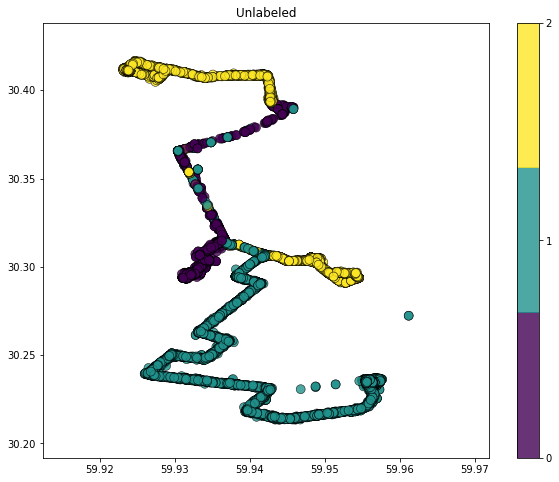

In [35]:
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('viridis', 3)
plt.scatter(unlabeled_data_th09['lat'], unlabeled_data_th09['log'], edgecolors='black', 
            c=unlabeled_data_th09['label'], linewidth=0.6, alpha=0.8, s=80, cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])             
plt.title('Unlabeled');

In [338]:
for algo in (forest, xgb_clf):
    algo.fit(X_mixed_train, y_mixed_train)
    print(algo.__class__, accuracy_score(y_valid, algo.predict(X_valid)))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.592
<class 'xgboost.sklearn.XGBClassifier'> 0.5713333333333334


In [340]:
for algo in (forest, xgb_clf):
    algo.fit(X_mixed_train[:, [0, 1]], y_mixed_train)
    print(algo.__class__, accuracy_score(y_valid, algo.predict(X_valid[:, [0, 1]])))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.574
<class 'xgboost.sklearn.XGBClassifier'> 0.574


In [341]:
for algo in (forest, xgb_clf):
    algo.fit(X_mixed_train[:, [0, 1, 2]], y_mixed_train)
    print(algo.__class__, accuracy_score(y_valid, algo.predict(X_valid[:, [0, 1, 2]])))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.5886666666666667
<class 'xgboost.sklearn.XGBClassifier'> 0.572


In [342]:
for algo in (forest, xgb_clf):
    algo.fit(X_mixed_train[:, [0, 1, 3]], y_mixed_train)
    print(algo.__class__, accuracy_score(y_valid, algo.predict(X_valid[:, [0, 1, 3]])))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.5893333333333334
<class 'xgboost.sklearn.XGBClassifier'> 0.571


In [39]:
n_estimators = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
for n in n_estimators:
    random_forest = RandomForestClassifier(n_estimators=n, min_samples_split=5, min_samples_leaf=1, random_state=17)
    random_forest.fit(X_mixed_train, y_mixed_train)
    print('n_estimators:', n, 'accuracy:', accuracy_score(y_valid, random_forest.predict(X_valid)))

n_estimators: 100 accuracy: 0.5913333333333334
n_estimators: 200 accuracy: 0.593
n_estimators: 400 accuracy: 0.5946666666666667
n_estimators: 600 accuracy: 0.5973333333333334
n_estimators: 800 accuracy: 0.597
n_estimators: 1000 accuracy: 0.5966666666666667
n_estimators: 1200 accuracy: 0.5933333333333334
n_estimators: 1400 accuracy: 0.595
n_estimators: 1600 accuracy: 0.5936666666666667
n_estimators: 1800 accuracy: 0.595
n_estimators: 2000 accuracy: 0.5943333333333334


In [37]:
forest = RandomForestClassifier(n_estimators=600, min_samples_split=5, min_samples_leaf=1, random_state=17)

In [42]:
y_unlabeled = unlabeled_data_th09['label'].values
X_full_train = np.vstack((labeled_data.drop('label', axis=1).values, 
                          unlabeled_data_th09.drop(['prob', 'label'], axis=1).values))
y_full_train = np.concatenate((labels, y_unlabeled))

In [43]:
X_full_train.shape, y_full_train.shape

((35176, 4), (35176,))

In [44]:
%%time
forest.fit(X_full_train, y_full_train)

CPU times: user 24.3 s, sys: 31.1 ms, total: 24.3 s
Wall time: 24.4 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [46]:
y_pred = forest.predict(test_data.values) # 0.7086
with open(os.path.join('data', 'transport_subm4.csv'), 'w') as f:
    f.write('\n'.join([str(y) for y in y_pred]))

In [15]:
add_real_time(data)
add_real_time(labeled_data)
add_real_time(train_data)
add_real_time(valid_data)
add_real_time(test_data)

In [18]:
def add_diff_ts(df):
    df['diff_ts'] = df['request_ts'] - df['trans_ts']

In [19]:
add_diff_ts(data)
add_diff_ts(labeled_data)
add_diff_ts(train_data)
add_diff_ts(valid_data)
add_diff_ts(test_data)

In [36]:
forest = RandomForestClassifier(n_estimators=100, random_state=17)

In [37]:
forest.fit(train_data[['log', 'lat', 'request_ts', 'trans_ts']], y_train)
accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', 'request_ts', 'trans_ts']]))

0.5866666666666667

In [18]:
add_numeric_time_features(data)
add_numeric_time_features(labeled_data)
add_numeric_time_features(train_data)
add_numeric_time_features(valid_data)
add_numeric_time_features(test_data)

In [39]:
%%time
numeric_time_features = ['hour', 'minute', 'second', 'HHMMSS', 'HHMM', 'MMSS', 'dow']
for time_feature in numeric_time_features:
    forest.fit(train_data[['log', 'lat', time_feature]], y_train)
    print(time_feature, accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', time_feature]])))

hour 0.5643333333333334
minute 0.533
second 0.532
HHMMSS 0.5823333333333334
HHMM 0.585
MMSS 0.5543333333333333
dow 0.5583333333333333
CPU times: user 6.69 s, sys: 6.75 ms, total: 6.69 s
Wall time: 6.69 s


In [40]:
%%time
numeric_time_features = ['hour', 'minute', 'second', 'HHMMSS', 'HHMM', 'MMSS', 'dow']
for time_feature in numeric_time_features:
    forest.fit(train_data[['log', 'lat', 'request_ts', time_feature]], y_train)
    print(time_feature, accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', 'request_ts', time_feature]])))

hour 0.5756666666666667
minute 0.5823333333333334
second 0.5623333333333334
HHMMSS 0.586
HHMM 0.588
MMSS 0.589
dow 0.5743333333333334
CPU times: user 10.2 s, sys: 177 µs, total: 10.2 s
Wall time: 10.2 s


In [42]:
%%time
numeric_time_features = ['hour', 'minute', 'second', 'HHMMSS', 'HHMM', 'MMSS', 'dow']
for time_feature in numeric_time_features:
    forest.fit(train_data[['log', 'lat', 'trans_ts', time_feature]], y_train)
    print(time_feature, accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', 
                                                                           'trans_ts', time_feature]])))

hour 0.583
minute 0.584
second 0.5586666666666666
HHMMSS 0.5833333333333334
HHMM 0.586
MMSS 0.585
dow 0.5766666666666667
CPU times: user 10.3 s, sys: 6.62 ms, total: 10.3 s
Wall time: 10.3 s


In [41]:
%%time
numeric_time_features = ['hour', 'minute', 'second', 'HHMMSS', 'HHMM', 'MMSS', 'dow']
for time_feature in numeric_time_features:
    forest.fit(train_data[['log', 'lat', 'request_ts', 'trans_ts', time_feature]], y_train)
    print(time_feature, accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', 'request_ts', 
                                                                           'trans_ts', time_feature]])))

hour 0.5883333333333334
minute 0.5906666666666667
second 0.5763333333333334
HHMMSS 0.5883333333333334
HHMM 0.5896666666666667
MMSS 0.5823333333333334
dow 0.5846666666666667
CPU times: user 10.3 s, sys: 3.49 ms, total: 10.3 s
Wall time: 10.3 s


** Unlabeled data with RandomForest + minute **

In [19]:
unlabeled_data = data[data['label'] == '-']
unlabeled_data.drop('label', axis=1, inplace=True)
unlabeled_data.shape

(43665, 13)

In [20]:
unlabeled_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,hour,minute,second,HHMMSS,HHMM,MMSS,dow
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,14,59,6,145906,1459,5906,2
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,14,59,7,145907,1459,5907,2
3,30.293602,59.938892,1511956827,1511956759,2017-11-29 15:00:27,2017-11-29 14:59:19,14,59,19,145919,1459,5919,2
4,30.360102,59.931103,1511956827,1511956767,2017-11-29 15:00:27,2017-11-29 14:59:27,14,59,27,145927,1459,5927,2
5,30.309683,59.940006,1511956827,1511956769,2017-11-29 15:00:27,2017-11-29 14:59:29,14,59,29,145929,1459,5929,2


In [21]:
forest.fit(labeled_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute']].values, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [22]:
unlabeled_probs = forest.predict_proba(unlabeled_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute']])
unlabeled_pred = unlabeled_probs.argmax(axis=1)

In [23]:
unlabeled_data['prob'] = unlabeled_probs.max(axis=1)
unlabeled_data['label'] = unlabeled_pred
unlabeled_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,hour,minute,second,HHMMSS,HHMM,MMSS,dow,prob,label
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,14,59,6,145906,1459,5906,2,0.80,1
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,14,59,7,145907,1459,5907,2,0.76,2
3,30.293602,59.938892,1511956827,1511956759,2017-11-29 15:00:27,2017-11-29 14:59:19,14,59,19,145919,1459,5919,2,0.62,1
4,30.360102,59.931103,1511956827,1511956767,2017-11-29 15:00:27,2017-11-29 14:59:27,14,59,27,145927,1459,5927,2,0.62,0
5,30.309683,59.940006,1511956827,1511956769,2017-11-29 15:00:27,2017-11-29 14:59:29,14,59,29,145929,1459,5929,2,0.54,1


In [24]:
unlabeled_data_th09 = unlabeled_data[unlabeled_data['prob'] > 0.9]
unlabeled_data_th09.shape

(23241, 15)

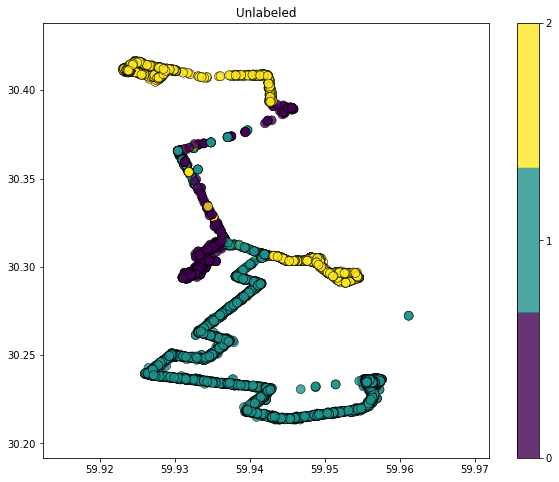

In [50]:
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('viridis', 3)
plt.scatter(unlabeled_data_th09['lat'], unlabeled_data_th09['log'], edgecolors='black', 
            c=unlabeled_data_th09['label'], linewidth=0.6, alpha=0.8, s=80, cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])             
plt.title('Unlabeled');

In [25]:
y_unlabeled = unlabeled_data_th09['label'].values
X_mixed_train = np.vstack((train_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute']].values, 
                           unlabeled_data_th09[['log', 'lat', 'request_ts', 'trans_ts', 'minute']].values))
y_mixed_train = np.concatenate((y_train, y_unlabeled))

In [26]:
X_mixed_train.shape, y_mixed_train.shape

((30241, 5), (30241,))

In [54]:
n_estimators = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
for n in n_estimators:
    random_forest = RandomForestClassifier(n_estimators=n, min_samples_split=5, min_samples_leaf=1, random_state=17)
    random_forest.fit(X_mixed_train, y_mixed_train)
    print('n_estimators:', n, 'accuracy:', accuracy_score(y_valid, 
                                                          random_forest.predict(valid_data[['log', 'lat', 
                                                                                            'request_ts', 'trans_ts',
                                                                                            'minute']])))

n_estimators: 100 accuracy: 0.5976666666666667
n_estimators: 200 accuracy: 0.6003333333333334
n_estimators: 400 accuracy: 0.5993333333333334
n_estimators: 600 accuracy: 0.5996666666666667
n_estimators: 800 accuracy: 0.5983333333333334
n_estimators: 1000 accuracy: 0.5986666666666667
n_estimators: 1200 accuracy: 0.6006666666666667
n_estimators: 1400 accuracy: 0.6006666666666667
n_estimators: 1600 accuracy: 0.6013333333333334
n_estimators: 1800 accuracy: 0.601
n_estimators: 2000 accuracy: 0.6016666666666667


In [104]:
forest = RandomForestClassifier(n_estimators=2000, min_samples_split=5, min_samples_leaf=1, random_state=17)

In [78]:
y_unlabeled = unlabeled_data_th09['label'].values
X_full_train = np.vstack((labeled_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute']].values, 
                          unlabeled_data_th09[['log', 'lat', 'request_ts', 'trans_ts', 'minute']].values))
y_full_train = np.concatenate((labels, y_unlabeled))

In [79]:
X_full_train.shape, y_full_train.shape

((33241, 5), (33241,))

In [105]:
%%time
forest.fit(X_full_train, y_full_train)

CPU times: user 1min 10s, sys: 260 ms, total: 1min 10s
Wall time: 1min 11s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [106]:
y_pred = forest.predict(test_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute']].values) #0.7122
with open(os.path.join('data', 'transport_subm5.csv'), 'w') as f:
    f.write('\n'.join([str(y) for y in y_pred]))

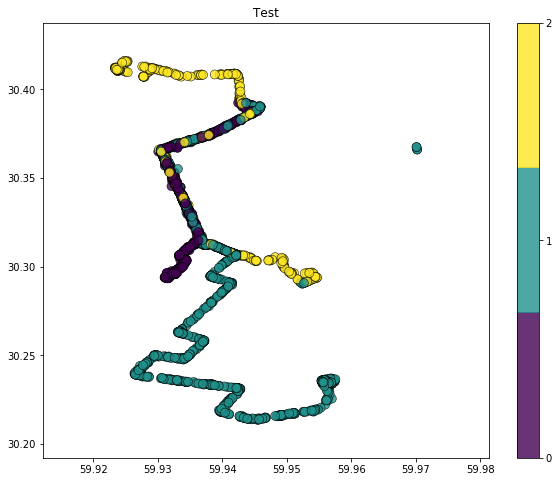

In [107]:
fig = plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('viridis', 3)
plt.scatter(test_data['lat'], test_data['log'], edgecolors='black', 
            c=y_pred, linewidth=0.6, alpha=0.8, s=80, cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])             
plt.title('Test');

In [ ]:
fig = plt.figure(figsize=(12, 22))

fig.add_subplot(3, 1, 1)
coordinates = labeled_data.query([['lat', 'log']].values
cmap = plt.get_cmap('viridis', 3)
plt.scatter(coordinates[:,0], coordinates[:,1], c=labels, edgecolors='black', linewidth=0.6, alpha=0.8, s=80, 
            cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])
plt.title('All Train')
plt.yticks(np.arange(30.2, 30.45, 0.01))
plt.xticks(np.arange(59.91, 59.98, 0.006))


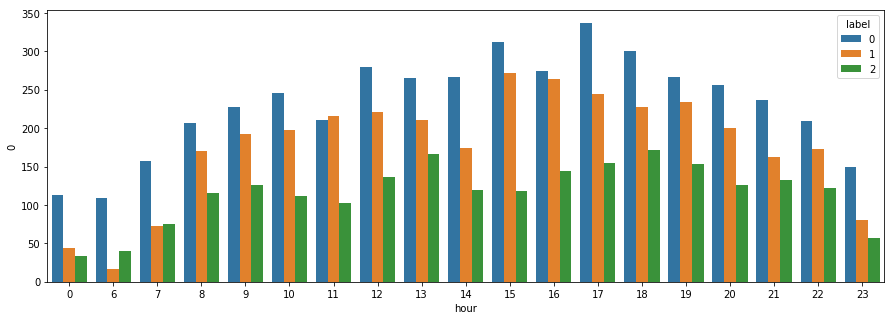

In [154]:
plt.figure(figsize=(15, 5))
gb_hour = labeled_data.groupby(['hour', 'label']).size().reset_index()
sns.barplot(data=gb_hour, x='hour', y=0, hue='label');

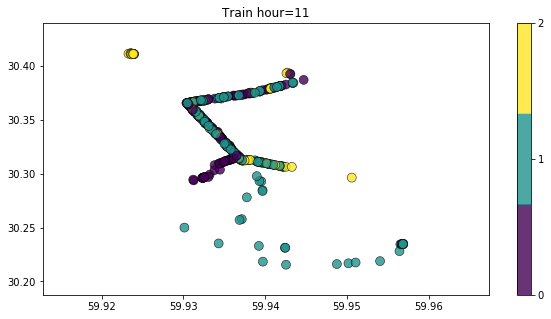

In [172]:
fig = plt.figure(figsize=(10, 5))

coordinates = labeled_data.query('hour == 11')[['lat', 'log']].values
y_cond = labeled_data.query('hour == 11')['label']

cmap = plt.get_cmap('viridis', 3)
plt.scatter(coordinates[:,0], coordinates[:,1], c=y_cond, edgecolors='black', linewidth=0.6, alpha=0.8, s=80, 
            cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])
plt.title('Train hour=11');

In [173]:
def is_11_hour(df):
    df['is_11_hour'] = (df['hour'] == 11).astype(int)

In [174]:
is_11_hour(data)
is_11_hour(labeled_data)
is_11_hour(train_data)
is_11_hour(valid_data)
is_11_hour(test_data)

In [180]:
forest.fit(train_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute', 'is_11_hour']], y_train)
print('is 11 hour feature', accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', 'request_ts', 
                                                                       'trans_ts', 'minute', 'is_11_hour']])))

is 11 hour feature 0.5853333333333334


In [40]:
def add_day_period(df):
    def get_day_period(hour):
        if 0 < hour <= 12:
            return 0
        elif 12 < hour <= 17:
            return 1
        elif hour > 17 or hour == 0:
            return 2
    df['day_period'] = df['hour'].apply(get_day_period).astype(int)

In [41]:
add_day_period(data)
add_day_period(labeled_data)
add_day_period(train_data)
add_day_period(valid_data)
add_day_period(test_data)

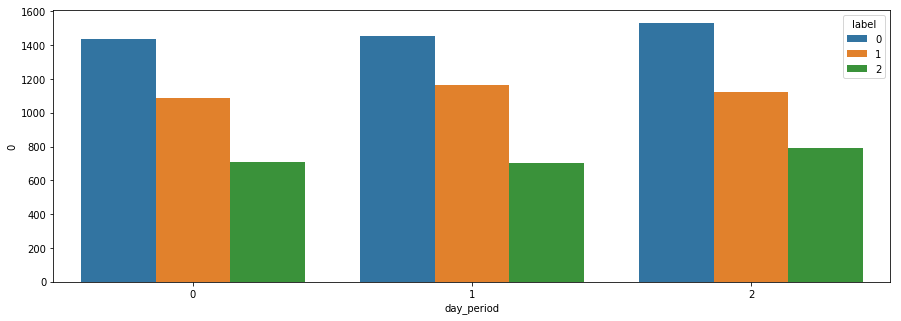

In [222]:
plt.figure(figsize=(15, 5))
gb_day_period = labeled_data.groupby(['day_period', 'label']).size().reset_index()
sns.barplot(data=gb_day_period, x='day_period', y=0, hue='label');

In [223]:
forest.fit(train_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute', 'day_period']], y_train)
print('day_period', accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', 'request_ts', 
                                                                       'trans_ts', 'minute', 'day_period']])))

day_period 0.5943333333333334


** Unlabeled data with RandomForest + minute **

In [21]:
unlabeled_data = data[data['label'] == '-']
unlabeled_data.drop('label', axis=1, inplace=True)
unlabeled_data.shape

(43665, 14)

In [22]:
unlabeled_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,hour,minute,second,HHMMSS,HHMM,MMSS,dow,day_period
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,14,59,6,145906,1459,5906,2,1
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,14,59,7,145907,1459,5907,2,1
3,30.293602,59.938892,1511956827,1511956759,2017-11-29 15:00:27,2017-11-29 14:59:19,14,59,19,145919,1459,5919,2,1
4,30.360102,59.931103,1511956827,1511956767,2017-11-29 15:00:27,2017-11-29 14:59:27,14,59,27,145927,1459,5927,2,1
5,30.309683,59.940006,1511956827,1511956769,2017-11-29 15:00:27,2017-11-29 14:59:29,14,59,29,145929,1459,5929,2,1


In [23]:
forest.fit(labeled_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute', 'day_period']].values, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [24]:
unlabeled_probs = forest.predict_proba(unlabeled_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute', 
                                                       'day_period']])
unlabeled_pred = unlabeled_probs.argmax(axis=1)

In [25]:
unlabeled_data['prob'] = unlabeled_probs.max(axis=1)
unlabeled_data['label'] = unlabeled_pred
unlabeled_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,hour,minute,second,HHMMSS,HHMM,MMSS,dow,day_period,prob,label
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,14,59,6,145906,1459,5906,2,1,0.83,1
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,14,59,7,145907,1459,5907,2,1,0.66,2
3,30.293602,59.938892,1511956827,1511956759,2017-11-29 15:00:27,2017-11-29 14:59:19,14,59,19,145919,1459,5919,2,1,0.72,1
4,30.360102,59.931103,1511956827,1511956767,2017-11-29 15:00:27,2017-11-29 14:59:27,14,59,27,145927,1459,5927,2,1,0.63,0
5,30.309683,59.940006,1511956827,1511956769,2017-11-29 15:00:27,2017-11-29 14:59:29,14,59,29,145929,1459,5929,2,1,0.64,1


In [26]:
unlabeled_data_th09 = unlabeled_data[unlabeled_data['prob'] > 0.9]
unlabeled_data_th09.shape

(20282, 16)

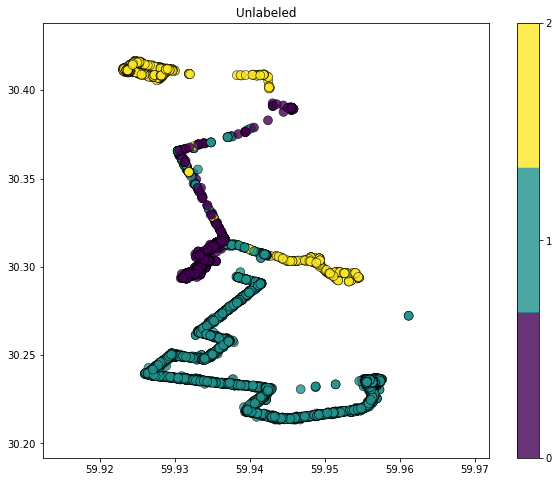

In [230]:
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('viridis', 3)
plt.scatter(unlabeled_data_th09['lat'], unlabeled_data_th09['log'], edgecolors='black', 
            c=unlabeled_data_th09['label'], linewidth=0.6, alpha=0.8, s=80, cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])             
plt.title('Unlabeled');

In [27]:
y_unlabeled = unlabeled_data_th09['label'].values
X_mixed_train = np.vstack((train_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute', 'day_period']].values, 
                           unlabeled_data_th09[['log', 'lat', 'request_ts', 'trans_ts', 'minute', 
                                                'day_period']].values))
y_mixed_train = np.concatenate((y_train, y_unlabeled))

In [28]:
X_mixed_train.shape, y_mixed_train.shape

((27282, 6), (27282,))

In [236]:
n_estimators = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
for n in n_estimators:
    random_forest = RandomForestClassifier(n_estimators=n, min_samples_split=5, min_samples_leaf=1, random_state=17)
    random_forest.fit(X_mixed_train, y_mixed_train)
    print('n_estimators:', n, 'accuracy:', accuracy_score(y_valid, 
                                                          random_forest.predict(valid_data[['log', 'lat', 
                                                                                            'request_ts', 'trans_ts',
                                                                                            'minute', 'day_period']])))

n_estimators: 100 accuracy: 0.596
n_estimators: 200 accuracy: 0.5963333333333334
n_estimators: 400 accuracy: 0.5946666666666667
n_estimators: 600 accuracy: 0.5993333333333334
n_estimators: 800 accuracy: 0.602
n_estimators: 1000 accuracy: 0.6016666666666667
n_estimators: 1200 accuracy: 0.6013333333333334
n_estimators: 1400 accuracy: 0.6006666666666667
n_estimators: 1600 accuracy: 0.5996666666666667
n_estimators: 1800 accuracy: 0.6013333333333334
n_estimators: 2000 accuracy: 0.599


In [38]:
def add_numeric_request_time_features(df):
    df['req_hour'] = df['request_time'].apply(lambda ts: ts.hour)
    df['req_minute'] = df['request_time'].apply(lambda ts: ts.minute)
    df['req_second'] = df['request_time'].apply(lambda ts: ts.second)
    df['req_HHMMSS'] = df['request_time'].apply(lambda ts: (ts.hour * 100 + ts.minute) * 100 + ts.second)
    df['req_HHMM'] = df['request_time'].apply(lambda ts: ts.hour * 100 + ts.minute)
    df['req_MMSS'] = df['request_time'].apply(lambda ts: ts.minute * 100 + ts.second)

In [39]:
add_numeric_request_time_features(data)
add_numeric_request_time_features(labeled_data)
add_numeric_request_time_features(train_data)
add_numeric_request_time_features(valid_data)
add_numeric_request_time_features(test_data)

In [261]:
%%time
# with trans minute
numeric_req_time_features = ['req_hour', 'req_minute', 'req_second', 'req_HHMMSS', 'req_HHMM', 'req_MMSS']
for time_feature in numeric_req_time_features:
    forest.fit(train_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute', time_feature]], y_train)
    print(time_feature, accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', 'request_ts', 
                                                                           'trans_ts', 'minute', time_feature]])))

req_hour 0.5923333333333334
req_minute 0.5833333333333334
req_second 0.5946666666666667
req_HHMMSS 0.5903333333333334
req_HHMM 0.5836666666666667
req_MMSS 0.5843333333333334
CPU times: user 8.34 s, sys: 0 ns, total: 8.34 s
Wall time: 8.41 s


In [262]:
%%time
numeric_req_time_features = ['req_hour', 'req_minute', 'req_second', 'req_HHMMSS', 'req_HHMM', 'req_MMSS']
for time_feature in numeric_req_time_features:
    forest.fit(train_data[['log', 'lat', 'request_ts', 'trans_ts', time_feature]], y_train)
    print(time_feature, accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', 'request_ts', 
                                                                           'trans_ts', time_feature]])))

req_hour 0.5853333333333334
req_minute 0.5846666666666667
req_second 0.5883333333333334
req_HHMMSS 0.578
req_HHMM 0.584
req_MMSS 0.5856666666666667
CPU times: user 8.94 s, sys: 3.5 ms, total: 8.94 s
Wall time: 8.99 s


In [263]:
def add_diff_features(df):
    df['diff_min'] = df['req_minute'] - df['minute']
    df['diff_second'] = df['req_second'] - df['second']    
    df['diff_HHMMSS'] = df['req_HHMMSS'] - df['HHMMSS']
    df['diff_HHMM'] = df['req_HHMM'] - df['HHMM']
    df['diff_MMSS'] = df['req_MMSS'] - df['MMSS']            

In [264]:
add_diff_features(data)
add_diff_features(labeled_data)
add_diff_features(train_data)
add_diff_features(valid_data)
add_diff_features(test_data)

In [265]:
%%time
numeric_diff_time_features = ['diff_min', 'diff_second', 'diff_HHMMSS', 'diff_HHMM', 'diff_MMSS']
for time_feature in numeric_diff_time_features:
    forest.fit(train_data[['log', 'lat', 'request_ts', 'trans_ts', time_feature]], y_train)
    print(time_feature, accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', 'request_ts', 
                                                                           'trans_ts', time_feature]])))

diff_min 0.5813333333333334
diff_second 0.5723333333333334
diff_HHMMSS 0.5683333333333334
diff_HHMM 0.5733333333333334
diff_MMSS 0.5606666666666666
CPU times: user 7.26 s, sys: 20 µs, total: 7.26 s
Wall time: 7.27 s


In [270]:
forest.fit(train_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute', 'req_second', 'day_period']], y_train)
accuracy_score(y_valid, forest.predict(valid_data[['log', 'lat', 'request_ts', 'trans_ts', 'minute', 'req_second', 
                                                   'day_period']]))

0.5923333333333334

In [52]:
forest.fit(train_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 'req_second', 'day_period']], y_train)
accuracy_score(y_valid, forest.predict(valid_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 'req_second', 
                                                   'day_period']]))

0.603

In [53]:
forest.fit(train_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 'req_second']], y_train)
accuracy_score(y_valid, forest.predict(valid_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 'req_second']]))

0.604

In [61]:
n_estimators = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
for n in n_estimators:
    random_forest = RandomForestClassifier(n_estimators=n, min_samples_split=5, min_samples_leaf=1, random_state=17)
    random_forest.fit(train_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 'req_second']], y_train)
    print('n_estimators:', n, 'accuracy:', accuracy_score(y_valid, random_forest.predict(valid_data[['x', 'y', 'z', 
                                                                                              'request_ts',
                                                                                              'trans_ts', 'minute', 
                                                                                              'req_second']])))

n_estimators: 100 accuracy: 0.6053333333333333
n_estimators: 200 accuracy: 0.6033333333333334
n_estimators: 400 accuracy: 0.613
n_estimators: 600 accuracy: 0.606
n_estimators: 800 accuracy: 0.6063333333333333
n_estimators: 1000 accuracy: 0.6053333333333333
n_estimators: 1200 accuracy: 0.6036666666666667
n_estimators: 1400 accuracy: 0.607
n_estimators: 1600 accuracy: 0.6043333333333333
n_estimators: 1800 accuracy: 0.6033333333333334
n_estimators: 2000 accuracy: 0.6046666666666667


** Unlabeled data with RandomForest + xyz + minute + req_second **

In [62]:
unlabeled_data = data[data['label'] == '-']
unlabeled_data.drop('label', axis=1, inplace=True)
unlabeled_data.shape

(43665, 23)

In [63]:
unlabeled_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,hour,minute,second,HHMMSS,...,req_hour,req_minute,req_second,req_HHMMSS,req_HHMM,req_MMSS,day_period,x,y,z
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,14,59,6,145906,...,15,0,27,150027,1500,27,1,-0.353008,0.898395,-0.261288
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,14,59,7,145907,...,15,0,27,150027,1500,27,1,-0.519045,0.820630,-0.239080
3,30.293602,59.938892,1511956827,1511956759,2017-11-29 15:00:27,2017-11-29 14:59:19,14,59,19,145919,...,15,0,27,150027,1500,27,1,-0.420256,0.873402,-0.246078
4,30.360102,59.931103,1511956827,1511956767,2017-11-29 15:00:27,2017-11-29 14:59:27,14,59,27,145927,...,15,0,27,150027,1500,27,1,-0.478295,0.845187,-0.238521
5,30.309683,59.940006,1511956827,1511956769,2017-11-29 15:00:27,2017-11-29 14:59:29,14,59,29,145929,...,15,0,27,150027,1500,27,1,-0.434123,0.866285,-0.247158


In [64]:
forest = RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=1, random_state=17)

In [65]:
forest.fit(labeled_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 'req_second']].values, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [66]:
unlabeled_probs = forest.predict_proba(unlabeled_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 
                                                       'minute', 'req_second']])
unlabeled_pred = unlabeled_probs.argmax(axis=1)

In [67]:
unlabeled_data['prob'] = unlabeled_probs.max(axis=1)
unlabeled_data['label'] = unlabeled_pred
unlabeled_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,hour,minute,second,HHMMSS,...,req_second,req_HHMMSS,req_HHMM,req_MMSS,day_period,x,y,z,prob,label
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,14,59,6,145906,...,27,150027,1500,27,1,-0.353008,0.898395,-0.261288,0.934649,1
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,14,59,7,145907,...,27,150027,1500,27,1,-0.519045,0.820630,-0.239080,0.915764,2
3,30.293602,59.938892,1511956827,1511956759,2017-11-29 15:00:27,2017-11-29 14:59:19,14,59,19,145919,...,27,150027,1500,27,1,-0.420256,0.873402,-0.246078,0.758634,1
4,30.360102,59.931103,1511956827,1511956767,2017-11-29 15:00:27,2017-11-29 14:59:27,14,59,27,145927,...,27,150027,1500,27,1,-0.478295,0.845187,-0.238521,0.612393,0
5,30.309683,59.940006,1511956827,1511956769,2017-11-29 15:00:27,2017-11-29 14:59:29,14,59,29,145929,...,27,150027,1500,27,1,-0.434123,0.866285,-0.247158,0.574287,1


In [68]:
unlabeled_data_th09 = unlabeled_data[unlabeled_data['prob'] > 0.9]
unlabeled_data_th09.shape

(23656, 25)

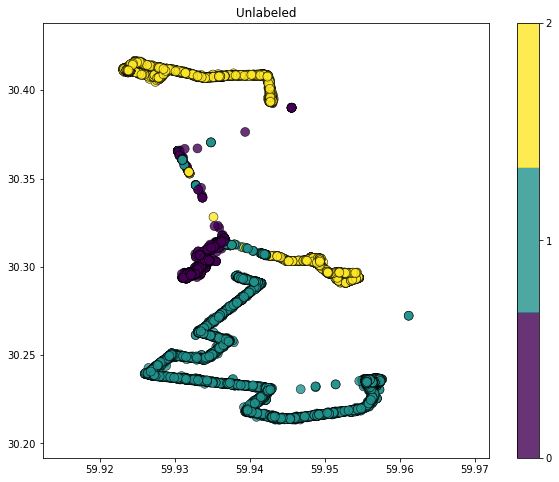

In [69]:
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('viridis', 3)
plt.scatter(unlabeled_data_th09['lat'], unlabeled_data_th09['log'], edgecolors='black', 
            c=unlabeled_data_th09['label'], linewidth=0.6, alpha=0.8, s=80, cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])             
plt.title('Unlabeled');

In [70]:
y_unlabeled = unlabeled_data_th09['label'].values
X_mixed_train = np.vstack((train_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 'req_second']].values, 
                           unlabeled_data_th09[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 
                                                'req_second']].values))
y_mixed_train = np.concatenate((y_train, y_unlabeled))

In [71]:
X_mixed_train.shape, y_mixed_train.shape

((30656, 7), (30656,))

In [72]:
n_estimators = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
for n in n_estimators:
    random_forest = RandomForestClassifier(n_estimators=n, min_samples_split=5, min_samples_leaf=1, random_state=17)
    random_forest.fit(X_mixed_train, y_mixed_train)
    print('n_estimators:', n, 'accuracy:', accuracy_score(y_valid, 
                                                          random_forest.predict(valid_data[['x', 'y', 'z', 
                                                                                            'request_ts', 
                                                                                            'trans_ts', 
                                                                                            'minute', 
                                                                                            'req_second']])))

n_estimators: 100 accuracy: 0.6003333333333334
n_estimators: 200 accuracy: 0.6126666666666667
n_estimators: 400 accuracy: 0.609
n_estimators: 600 accuracy: 0.6096666666666667
n_estimators: 800 accuracy: 0.6086666666666667
n_estimators: 1000 accuracy: 0.6076666666666667
n_estimators: 1200 accuracy: 0.6066666666666667
n_estimators: 1400 accuracy: 0.6063333333333333
n_estimators: 1600 accuracy: 0.6063333333333333
n_estimators: 1800 accuracy: 0.6063333333333333
n_estimators: 2000 accuracy: 0.607


** Обучим unlabeled данные со 100 деревьями **

In [91]:
forest = RandomForestClassifier(n_estimators=100,  random_state=17)

In [92]:
forest.fit(labeled_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 'req_second']].values, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [93]:
unlabeled_probs = forest.predict_proba(unlabeled_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 
                                                       'minute', 'req_second']])
unlabeled_pred = unlabeled_probs.argmax(axis=1)

In [94]:
unlabeled_data['prob'] = unlabeled_probs.max(axis=1)
unlabeled_data['label'] = unlabeled_pred
unlabeled_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,hour,minute,second,HHMMSS,...,req_second,req_HHMMSS,req_HHMM,req_MMSS,day_period,x,y,z,prob,label
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,14,59,6,145906,...,27,150027,1500,27,1,-0.353008,0.898395,-0.261288,0.95,1
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,14,59,7,145907,...,27,150027,1500,27,1,-0.519045,0.820630,-0.239080,0.89,2
3,30.293602,59.938892,1511956827,1511956759,2017-11-29 15:00:27,2017-11-29 14:59:19,14,59,19,145919,...,27,150027,1500,27,1,-0.420256,0.873402,-0.246078,0.79,1
4,30.360102,59.931103,1511956827,1511956767,2017-11-29 15:00:27,2017-11-29 14:59:27,14,59,27,145927,...,27,150027,1500,27,1,-0.478295,0.845187,-0.238521,0.57,0
5,30.309683,59.940006,1511956827,1511956769,2017-11-29 15:00:27,2017-11-29 14:59:29,14,59,29,145929,...,27,150027,1500,27,1,-0.434123,0.866285,-0.247158,0.55,1


In [95]:
unlabeled_data_th09 = unlabeled_data[unlabeled_data['prob'] > 0.9]
unlabeled_data_th09.shape

(23856, 25)

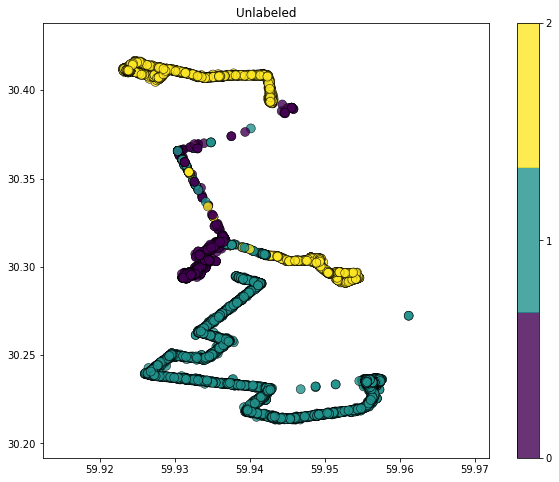

In [96]:
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('viridis', 3)
plt.scatter(unlabeled_data_th09['lat'], unlabeled_data_th09['log'], edgecolors='black', 
            c=unlabeled_data_th09['label'], linewidth=0.6, alpha=0.8, s=80, cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])             
plt.title('Unlabeled');

In [97]:
y_unlabeled = unlabeled_data_th09['label'].values
X_mixed_train = np.vstack((train_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 'req_second']].values, 
                           unlabeled_data_th09[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 
                                                'req_second']].values))
y_mixed_train = np.concatenate((y_train, y_unlabeled))

In [98]:
X_mixed_train.shape, y_mixed_train.shape

((30856, 7), (30856,))

In [99]:
n_estimators = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
for n in n_estimators:
    random_forest = RandomForestClassifier(n_estimators=n, min_samples_split=5, min_samples_leaf=1, random_state=17)
    random_forest.fit(X_mixed_train, y_mixed_train)
    print('n_estimators:', n, 'accuracy:', accuracy_score(y_valid, 
                                                          random_forest.predict(valid_data[['x', 'y', 'z', 
                                                                                            'request_ts', 
                                                                                            'trans_ts', 
                                                                                            'minute', 
                                                                                            'req_second']])))

n_estimators: 100 accuracy: 0.604
n_estimators: 200 accuracy: 0.6096666666666667
n_estimators: 400 accuracy: 0.6113333333333333
n_estimators: 600 accuracy: 0.611
n_estimators: 800 accuracy: 0.6093333333333333
n_estimators: 1000 accuracy: 0.6103333333333333
n_estimators: 1200 accuracy: 0.61
n_estimators: 1400 accuracy: 0.61
n_estimators: 1600 accuracy: 0.613
n_estimators: 1800 accuracy: 0.613
n_estimators: 2000 accuracy: 0.6113333333333333


In [100]:
forest = RandomForestClassifier(n_estimators=1600, min_samples_split=5, min_samples_leaf=1, random_state=17)

In [101]:
y_unlabeled = unlabeled_data_th09['label'].values
X_full_train = np.vstack((labeled_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 
                                                'req_second']].values, 
                          unlabeled_data_th09[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 
                                                'req_second']].values))
y_full_train = np.concatenate((labels, y_unlabeled))

In [102]:
X_full_train.shape, y_full_train.shape

((33856, 7), (33856,))

In [103]:
%%time
forest.fit(X_full_train, y_full_train)

CPU times: user 55.8 s, sys: 123 ms, total: 56 s
Wall time: 56.5 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [104]:
y_pred = forest.predict(test_data[['x', 'y', 'z', 'request_ts', 'trans_ts', 'minute', 'req_second']].values) #0.7256
with open(os.path.join('data', 'transport_subm6.csv'), 'w') as f:
    f.write('\n'.join([str(y) for y in y_pred]))

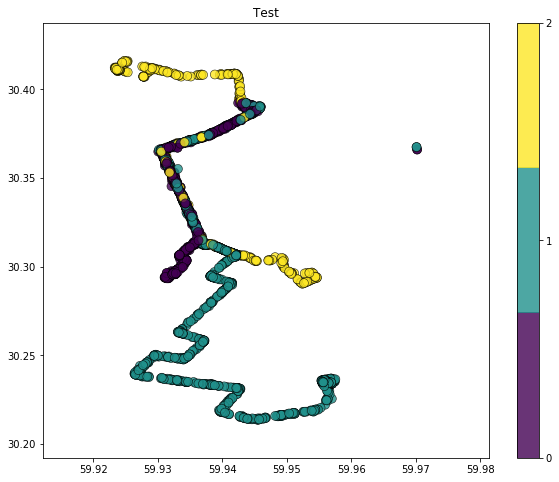

In [105]:
fig = plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('viridis', 3)
plt.scatter(test_data['lat'], test_data['log'], edgecolors='black', 
            c=y_pred, linewidth=0.6, alpha=0.8, s=80, cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])             
plt.title('Test');